In [1]:
import sys
import os
sys.path.append(os.path.abspath("..")) 

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import torch
from src.pipelines import VaeProcessor
from diffusers import UNet2DConditionModel, DDPMScheduler

device = 'cuda:0'   


/home/yasin/Projects/elixr-diffusion/.venv/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
import pickle

file_path = "./data/embeddings.pkl"


with open(file_path, "rb") as f:
    embeddings = pickle.load(f)

text_embeds = embeddings["texts"]
latents = embeddings["latents"]






In [5]:
unet = UNet2DConditionModel.from_pretrained("./output/checkpoint-final", subfolder="unet")
unet = unet.to(device)

scheduler = DDPMScheduler()

vae_processor = VaeProcessor(device=device)


In [21]:

sample_text = text_embeds[100]
sample_latent = latents[100]


torch_text = torch.tensor(sample_text)
torch_latent = torch.tensor(sample_latent)

if torch_text.shape[0] < 77:
    torch_text = torch.cat([torch_text, torch.zeros(77 - torch_text.shape[0], 768)], dim=0)

elif torch_text.shape[0] > 77:
    torch_text = torch_text[:77]


torch_text = torch_text.unsqueeze(0).to(device)
torch_latent = torch_latent.unsqueeze(0).to(device)

print(torch_text.shape)
print(torch_latent.shape)

torch.Size([1, 77, 768])
torch.Size([1, 4, 28, 28])


In [25]:
num_steps = 25

scheduler.set_timesteps(num_steps)


torch_text = None

torch_text = torch.zeros(1, 77, 768).to(device)

In [26]:
latent = torch_latent * scheduler.init_noise_sigma

for i,t in enumerate(scheduler.timesteps):
    latent_model_input = scheduler.scale_model_input(latent, t)


    noise_pred = unet(
        latent_model_input,
        t,
        encoder_hidden_states = torch_text,
        return_dict=False
    )[0]

    latent = scheduler.step(noise_pred, t, latent, return_dict=False)[0]




RuntimeError: mat1 and mat2 shapes cannot be multiplied (784x128 and 768x128)

torch.Size([1, 4, 28, 28])


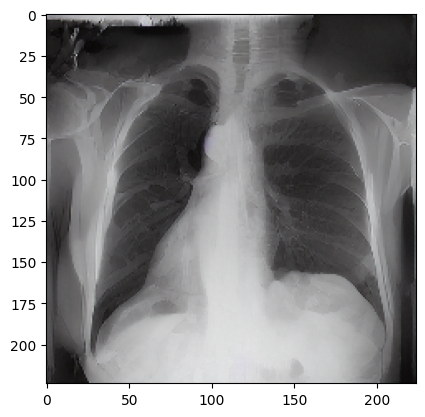

In [ ]:

print(latent.shape)
#decode 

output = vae_processor.decode_latent(latent)


import matplotlib.pyplot as plt

plt.imshow(output)